In [1]:
from pandas import read_html, concat
from collections import defaultdict
from string import lower
import requests
import re
import numpy as np

In [2]:
matches_urls = [
    "https://www.collegeswimming.com/team/376/results/?status=latest", # yale
    "https://www.collegeswimming.com/team/134/results/?status=latest", # harvard
    "https://www.collegeswimming.com/team/272/results/?status=latest", # dartmouth
    "https://www.collegeswimming.com/team/283/results/?status=latest", # columbia
    "https://www.collegeswimming.com/team/17/results/?status=latest",  # brown
    "https://www.collegeswimming.com/team/416/results/?status=latest", # upenn
    "https://www.collegeswimming.com/team/477/results/?status=latest", # princeton
    "https://www.collegeswimming.com/team/258/results/?status=latest"  # cornell
]

In [3]:
links = []
for match_url in matches_urls:
    r = requests.get(match_url)
    links += re.findall("/results/\d+", r.text)
links = list(set(links))

In [4]:
def swims_for_link(link):
    frames = []
    for k in range(1, 20):
        url = "https://www.collegeswimming.com%s/topswims/?page=%d" % (link, k)
        dataframe = read_html(url)
        if len(dataframe) == 0:
            break
        frames.append(dataframe[0])
    dataframe = concat(frames, ignore_index=True)
    return dataframe.T.to_dict().values()

In [91]:
results_by_person = defaultdict(lambda: defaultdict(list))
for i, link in enumerate(links):
    print("%d / %d" % (i, len(links)))
    swims = swims_for_link(link)
    if len(swims) < 20:
        print 'skipping ', link
        continue
    for swim in swims:
        name = swim['Name']
        event = swim['Event']
        if 'Diving' in event:
            continue
        time = swim['Time']
        if type(time) != float and ':' in time:
            minutes, seconds = time.split(':')
            time = float(minutes) * 60 + float(seconds)
        try:
            time = float(time)
        except:
            continue
        results_by_person[name][event].append(time)

0 / 48
1 / 48
2 / 48
3 / 48
4 / 48
5 / 48
6 / 48
7 / 48
8 / 48
9 / 48
10 / 48
11 / 48
12 / 48
13 / 48
14 / 48
15 / 48
16 / 48
17 / 48
18 / 48
19 / 48
20 / 48
21 / 48
22 / 48
23 / 48
24 / 48
25 / 48
26 / 48
27 / 48
28 / 48
29 / 48
30 / 48
31 / 48
32 / 48
33 / 48
34 / 48
35 / 48
36 / 48
37 / 48
38 / 48
39 / 48
40 / 48
41 / 48
42 / 48
43 / 48
44 / 48
45 / 48
46 / 48
47 / 48


In [92]:
import json
string = json.dumps(results_by_person)
with open("results.json", 'w') as outfile:
    outfile.write(string)

In [5]:
import json
with open("results.json") as infile:
    results_by_person = json.loads(infile.read())

In [6]:
for person in results_by_person:
    for event in results_by_person[person]:
        results_by_person[person][event] = list(set(results_by_person[person][event]))

In [20]:
import csv
people = {}
with open("women.csv") as people_file:
    reader = csv.DictReader(people_file)
    for row in reader:
        name = row["full_name_computed"]
        last, first = name.split(",")
        name = (first + " " + last).strip()
        if name == "Bella Hindley":
            name = "Isabella Hindley"
        people[name] = row["team_short_name"]

In [8]:
events = []
for person in results_by_person:
    events = list(set(events + results_by_person[person].keys()))

In [9]:
def simulate_event(event, sims=10000):
    # compute mean and variance for participants
    participants = {}
    for person in results_by_person:
        # skip people who have not competed in the given event
        if event not in results_by_person[person] or person not in people:
            continue
        mean = np.mean(results_by_person[person][event])
        std = np.std(results_by_person[person][event])
        participants[person] = (mean, std)
        
#     print(participants["Kei Hyogo"])
#     print(participants["Dean Farris"])
    
    scores = defaultdict(float)
    for i in range(sims):
        results = []
        for person in participants:
            mean, std = participants[person]
            results.append((person, np.random.normal(mean, std + 0.0001)))
        results = sorted(results, key=lambda x: x[1])
        for i, (person, time) in enumerate(results):
            if i > 24:
                break
            score = 24 - i
            scores[person] += score / float(sims)
    
    return scores

In [21]:
scores = {}
for event in events:
    print(event)
    scores[event] = simulate_event(event)
    if len(scores[event]) < 4:
        del scores[event]

200 Free
50 Free
1000 Free
100 Back
200 Fly
100 Free
500 Free
100 Breast
200 Back
100 Fly
50 Back
100 IM
200 IM
400 IM
1650 Free
200 Breast


In [24]:
sorted(total_scores.items(), key=lambda x: -x[1])

[(u'Miki Dahlke', 98.13539999999166),
 (u'Claire Pinson', 88.37239999999906),
 (u'Mary Ashby', 82.5717999999964),
 (u'Victoria Chan', 82.37389999999486),
 (u'Christie Chong', 78.55509999999745),
 (u'Isabel Reis', 71.28929999999512),
 (u'Jessica Antiles', 69.67220000000177),
 (u'Shaelyn Choi', 69.10379999999498),
 (u'Kristina Li', 68.95780000000852),
 (u'Gianna Garcia', 68.64870000000558),
 (u'Lili Margitai', 67.4630000000002),
 (u'Kina Zhou', 66.81980000000654),
 (u'Isabella Hindley', 64.4458000000032),
 (u'Joanna Curry', 64.162899999997),
 (u'Ashlee Korsberg', 63.571999999999775),
 (u'Destiny Nelson', 62.07000000000094),
 (u'Sarah Welch', 60.201399999997605),
 (u'Helen Hsu', 59.56239999999778),
 (u'Bebe Thompson', 57.55949999999514),
 (u'Summer Schmitt', 57.14620000000044),
 (u'Elaine Zhou', 56.20189999999706),
 (u'Brittany Usinger', 55.746700000008055),
 (u"Cha O'Leary", 55.088900000006085),
 (u'Lisa Zhang', 53.72449999999703),
 (u'Danielle Liu', 52.404300000004234),
 (u'Amy Zhang', 

In [29]:
import matplotlib.pyplot as plt

In [23]:
event_scores = defaultdict(list)
for event in scores:
    for person in scores[event]:
        event_scores[person].append(scores[event][person])

for key in event_scores:
    event_scores[key] = sorted(event_scores[key], reverse=True)
    
total_scores = {}
for key in event_scores:
    total_scores[key] = sum(event_scores[key][:5])

In [31]:
xs = [event_scores[key][0] for key in event_scores]
ys = [event_scores[key][1] if len(event_scores[key]) > 1 else 0 for key in event_scores]
sizes = [event_scores[key][2] * 3 if len(event_scores[key]) > 2 else 0 for key in event_scores]
teams = [people[key] for key in event_scores]
colors = {
    "Yale": "blue",
    "Harvard": "red",
    "Cornell": "purple",
    "Penn": "lightblue",
    "Dartmouth": "green",
    "Princeton": "orange",
    "Columbia": "lightblue",
    "Brown": "brown"
}

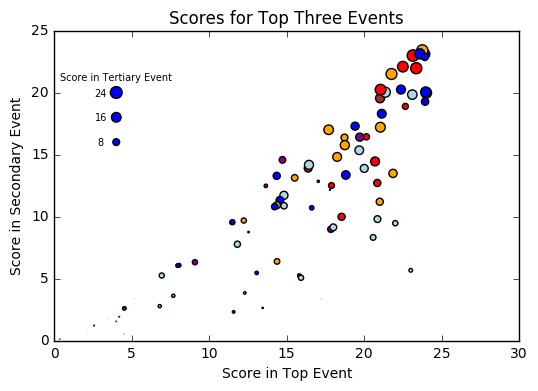

In [32]:
plt.scatter(xs, ys, c=[colors[team] for team in teams], s=sizes)
for i, key in enumerate(event_scores):
    if key not in ['Aaron Greenberg']:
        continue
    if key == 'Kei Hyogo':
        plt.annotate(key, (xs[i] - 5.5,ys[i]))
    else:
        plt.annotate(key, (xs[i] + 0.5,ys[i]))
plt.xlabel("Score in Top Event")
plt.ylabel("Score in Secondary Event")
plt.xlim(0, 30)
plt.ylim(0, 25)
plt.title("Scores for Top Three Events")
plt.scatter([4, 4, 4], [16, 18, 20], s=[24, 48, 72])
plt.annotate("Score in Tertiary Event", xy=(4, 21), fontsize=7, horizontalalignment='center')
plt.annotate("24", xy=(3, 19.7), fontsize=7, horizontalalignment='center')
plt.annotate("16", xy=(3, 17.7), fontsize=7, horizontalalignment='center')
plt.annotate("8", xy=(3, 15.7), fontsize=7, horizontalalignment='center')
plt.show()

In [140]:
sorted(total_scores.items(), key=lambda x: -x[1])

[(u'Miki Dahlke', 100.1434999999924),
 (u'Claire Pinson', 88.36949999999875),
 (u'Mary Ashby', 85.34239999999696),
 (u'Victoria Chan', 84.19250000000007),
 (u'Christie Chong', 78.48099999999732),
 (u'Isabel Reis', 72.75039999999498),
 (u'Jessica Antiles', 70.06930000000158),
 (u'Lili Margitai', 69.43250000000099),
 (u'Shaelyn Choi', 69.09269999999512),
 (u'Kristina Li', 68.96220000000875),
 (u'Gianna Garcia', 68.66260000000537),
 (u'Kina Zhou', 68.16750000000698),
 (u'Joanna Curry', 64.1935999999968),
 (u'Ashlee Korsberg', 63.58299999999977),
 (u'Destiny Nelson', 62.814400000000745),
 (u'Helen Hsu', 60.38489999999762),
 (u'Sarah Welch', 60.210899999997736),
 (u'Bebe Thompson', 57.57719999999517),
 (u'Summer Schmitt', 57.17940000000047),
 (u'Elaine Zhou', 55.996399999997095),
 (u'Brittany Usinger', 55.77160000000799),
 (u"Cha O'Leary", 55.11300000000614),
 (u'Lisa Zhang', 53.679699999997),
 (u'Danielle Liu', 52.578900000004225),
 (u'Amy Zhang', 49.93580000000069),
 (u'Chloe Close', 48.7

In [25]:
total_scores["Isabella Hindley"]

64.4458000000032

In [19]:
scores["50 Free"]["Isabella Hindley"]

0.0

In [130]:
sum((np.random.normal(98.484999999999999, 0.52499999999999147, 100000) 
 - np.random.normal(96.50333333333333, 1.7314027710372772, 100000)) > 0)

86134

In [77]:
simulate_event("200 Free")

(98.484999999999999, 0.52499999999999147)
(96.50333333333333, 1.7314027710372772)


defaultdict(float,
            {u'Aaron Glas': 0.0004,
             u'Adrian Lin': 3.723300000000054,
             u'Aly Abdel Khalik': 7.179800000000063,
             u'Austin Ryan': 5.176600000000031,
             u'Ben Schafer': 4.512100000000025,
             u'Brandon Sweezer': 1.053099999999994,
             u'Brennan Novak': 17.17919999999999,
             u'Bruno Korbar': 0.0009,
             u'Carter Jacobsen': 0.05940000000000002,
             u'Charles Steele': 2.845800000000063,
             u'Christian Feiler': 0.0007999999999999999,
             u'Christopher Miller': 0.7693999999999627,
             u'Cody Cline': 12.278100000000181,
             u'Coley Sullivan': 3.35440000000001,
             u'Colin McHugh': 0.5100999999999989,
             u'Connor Fraser': 6.061199999999922,
             u'Dean Farris': 21.47140000000119,
             u'Dylan Curtis': 0.720399999999997,
             u'Erik Cox': 0.3030000000000004,
             u'Gavin Springer': 9.556499999999682,

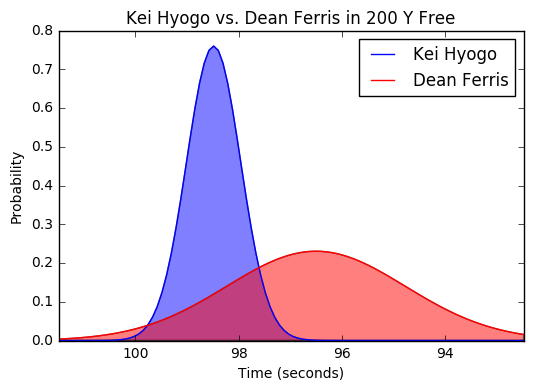

In [21]:
import matplotlib.mlab as mlab

mu1, sigma1 = (98.484999999999999, 0.52499999999999147)
mu2, sigma2 = (96.50333333333333, 1.7314027710372772)
x = np.linspace(mu1 - 6, mu1 + 3, 100)
plt.plot(x,mlab.normpdf(x, mu1, sigma1), color="blue")
plt.fill_between(x, 0, mlab.normpdf(x, mu1, sigma1), facecolor='blue', alpha=0.5)
plt.plot(x,mlab.normpdf(x, mu2, sigma2), color="red")
plt.fill_between(x, 0, mlab.normpdf(x, mu2, sigma2), facecolor='red', alpha=0.5)
plt.xlabel("Time (seconds)")
plt.ylabel("Probability")
plt.xlim(mu1-6, mu1+3)
plt.ylim(0, 0.8)
plt.gca().invert_xaxis()
plt.title("Kei Hyogo vs. Dean Ferris in 200 Y Free")
plt.legend(["Kei Hyogo", "Dean Ferris"])
plt.show()

In [26]:
for i, (player, score) in enumerate(sorted(total_scores.items(), key=lambda x: -x[1])):
    if people[player] == "Yale":
        print i, player

10 Lili Margitai
11 Kina Zhou
12 Isabella Hindley
15 Destiny Nelson
18 Bebe Thompson
22 Cha O'Leary
24 Danielle Liu
28 Sophie Pilkinton
30 Michelle Chintanaphol
31 Sophie Fontaine
43 Cailley Silbert
47 Kendall Brent
51 Olivia Jameson
55 Lilla Felix
56 Carrie Heilbrun
59 Isla Hutchinson-Maddox
64 Kate Rogers
68 Sydney Hirschi
75 Ashley Pales
83 Mackenzie Franklin
94 Amy Zhao
95 Cheryl Xiang
98 Alexa Kalandiak
104 Cassidy Richards


In [27]:
counts = defaultdict(float)
for player, score in sorted(total_scores.items(), key=lambda x: -x[1])[:50]:
    counts[people[player]] += 1

In [35]:
counts

defaultdict(float,
            {'Brown': 4.0,
             'Columbia': 9.0,
             'Cornell': 3.0,
             'Harvard': 12.0,
             'Penn': 1.0,
             'Princeton': 10.0,
             'Yale': 11.0})

In [121]:
for key in scores:
    print(key, scores[key]["Dean Farris"])

(u'200 Free', 21.509200000001172)
(u'50 Free', 22.36630000000129)
(u'1000 Free', 0.0)
(u'100 Breast', 0.0)
(u'200 Fly', 0.0)
(u'1650 Free', 0.0)
(u'500 Free', 0.0)
(u'100 Back', 23.727000000003898)
(u'200 Back', 22.696800000001623)
(u'100 Fly', 21.282899999998865)
(u'50 Back', 17.636699999997035)
(u'200 IM', 0.0)
(u'400 IM', 0.0)
(u'100 Free', 23.190400000002622)
(u'200 Breast', 0.0)


In [122]:
scores["100 Back"]["Kei Hyogo"]

0.0

In [116]:
print(event_scores["Kei Hyogo"])

[23.294200000002693, 22.873300000002033, 22.711200000002552, 20.730399999998962, 19.758399999998307, 19.138499999997343, 18.037499999998797, 17.818199999997702]


In [123]:
mlab.normpdf(x, mu1, sigma1)

array([  3.30112636e-29,   2.35292638e-28,   1.62754292e-27,
         1.09253280e-26,   7.11728632e-26,   4.49958346e-25,
         2.76062938e-24,   1.64369722e-23,   9.49759088e-23,
         5.32577746e-22,   2.89821429e-21,   1.53057950e-20,
         7.84439060e-20,   3.90157941e-19,   1.88321373e-18,
         8.82138330e-18,   4.01006762e-17,   1.76906837e-16,
         7.57382842e-16,   3.14676439e-15,   1.26879340e-14,
         4.96472867e-14,   1.88528948e-13,   6.94765897e-13,
         2.48471660e-12,   8.62369027e-12,   2.90460687e-11,
         9.49422435e-11,   3.01168497e-10,   9.27123338e-10,
         2.76976808e-09,   8.03021586e-09,   2.25937830e-08,
         6.16919658e-08,   1.63473057e-07,   4.20379647e-07,
         1.04909568e-06,   2.54077634e-06,   5.97166855e-06,
         1.36208081e-05,   3.01500457e-05,   6.47665846e-05,
         1.35018083e-04,   2.73156035e-04,   5.36299736e-04,
         1.02183856e-03,   1.88944786e-03,   3.39051334e-03,
         5.90437487e-03,

In [36]:
import csv
women = {}
with open("women.csv") as people_file:
    reader = csv.DictReader(people_file)
    for row in reader:
        name = row["full_name_computed"]
        last, first = name.split(",")
        name = (first + " " + last).strip()
        women[name] = row["team_short_name"]
        
women = people
        
men = {}
with open("people.csv") as people_file:
    reader = csv.DictReader(people_file)
    for row in reader:
        name = row["full_name_computed"]
        last, first = name.split(",")
        name = (first + " " + last).strip()
        men[name] = row["team_short_name"]

In [37]:
import csv
outfile = "women_data.csv"
with open(outfile, 'w') as outf:
    writer = csv.writer(outf)

    writer.writerow(["Name", "Team", "Total Score", 
                                              "Event 1 Score", "Event 2 Score", 
                                              "Event 3 Score"])
    for name in women:
        try:
            row = [name, women[name], total_scores[name]] + event_scores[name][:3]
            while len(row) < 6:
                row.append(0)
        except KeyError:
            continue
        writer.writerow(row)
 

In [42]:
import csv
outfile = "men_data.csv"
with open(outfile, 'w') as outf:
    writer = csv.writer(outf)

    writer.writerow(["Name", "Team", "Total Score", 
                                              "Event 1 Score", "Event 2 Score", 
                                              "Event 3 Score"])
    for name in men:
        try:
            row = [name, men[name], total_scores[name]] + event_scores[name][:3]
            while len(row) < 6:
                row.append(0)
        except KeyError:
            continue
        writer.writerow(row)